In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import gsw

plt.rcParams["figure.figsize"] = (6, 8)


In [ ]:
import pandas as pd

FILE_PATH = r"C:\Users\ADITYA GUPTA\POSEIDON\data\argo_data_20251221_173238.csv"   # update path if needed
df = pd.read_csv(FILE_PATH)

df.head()


,platform_number,latitude,longitude,time,pres,temp,psal
0,3902005,42.345547,34.792247,2024-01-03 21:04:00+00:00,2.9,11.560,21.222
1,3902005,42.345547,34.792247,2024-01-03 21:04:00+00:00,3.9,11.562,21.703
2,3902005,42.345547,34.792247,2024-01-03 21:04:00+00:00,5.0,11.561,21.487
3,3902005,42.345547,34.792247,2024-01-03 21:04:00+00:00,6.1,11.561,21.112
4,3902005,42.345547,34.792247,2024-01-03 21:04:00+00:00,6.9,11.560,21.318


In [ ]:
REQUIRED_COLS = ["pres", "temp", "psal", "latitude", "longitude"]

missing = set(REQUIRED_COLS) - set(df.columns)
assert not missing, f"Missing columns: {missing}"


In [ ]:
def quality_control(df):
    df = df.copy()

    df = df[df["pres"] >= 0]
    df = df[df["temp"].between(-2, 40)]
    df = df[df["psal"].between(0, 42)]

    df = df.sort_values("pres")
    df = df.dropna()

    return df

df_qc = quality_control(df)


In [ ]:
def bin_profile(df, step=10):
    df["pres_bin"] = (df["pres"] // step) * step
    return df.groupby("pres_bin").mean(numeric_only=True).reset_index()

df_bin = bin_profile(df_qc)


In [ ]:
df_bin["temp_smooth"] = savgol_filter(
    df_bin["temp"], window_length=7, polyorder=2
)

df_bin["psal_smooth"] = savgol_filter(
    df_bin["psal"], window_length=7, polyorder=2
)


In [ ]:
lat = df_bin["latitude"].iloc[0]
lon = df_bin["longitude"].iloc[0]

SA = gsw.SA_from_SP(
    df_bin["psal_smooth"],
    df_bin["pres_bin"],
    lon,
    lat
)

CT = gsw.CT_from_t(
    SA,
    df_bin["temp_smooth"],
    df_bin["pres_bin"]
)

df_bin["density_sigma0"] = gsw.sigma0(SA, CT)


In [ ]:
df_bin["dT_dz"] = np.gradient(
    df_bin["temp_smooth"],
    df_bin["pres_bin"]
)

df_bin["dS_dz"] = np.gradient(
    df_bin["psal_smooth"],
    df_bin["pres_bin"]
)

thermocline_depth = df_bin.loc[
    df_bin["dT_dz"].abs().idxmax(),
    "pres_bin"
]


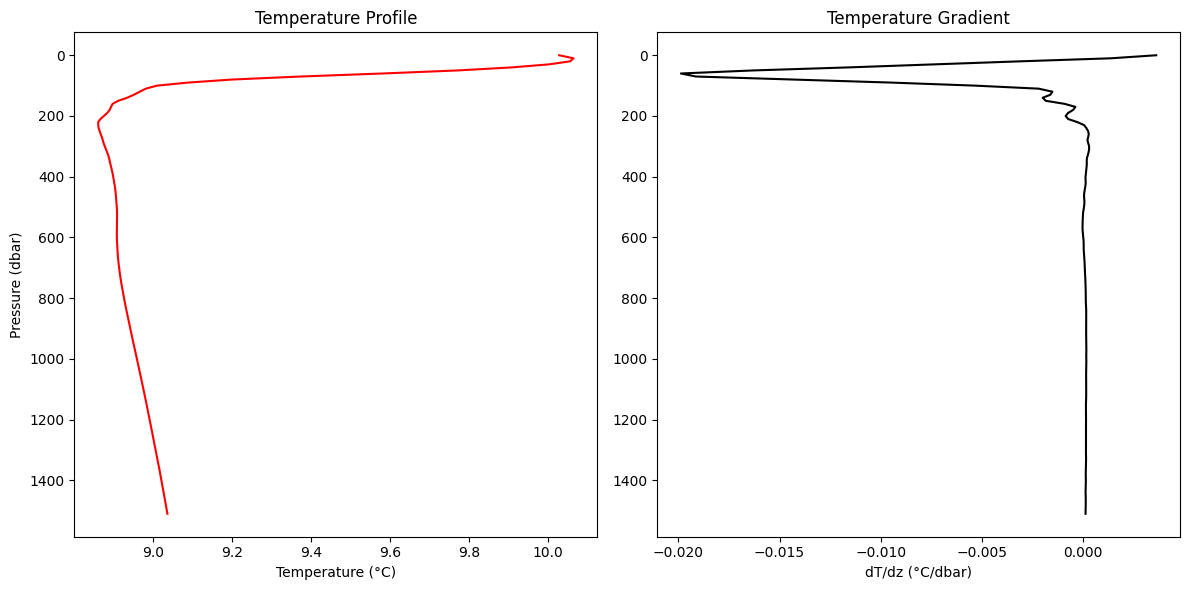

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(df_bin["temp_smooth"], df_bin["pres_bin"], color="red")
ax[0].invert_yaxis()
ax[0].set_xlabel("Temperature (°C)")
ax[0].set_ylabel("Pressure (dbar)")
ax[0].set_title("Temperature Profile")

ax[1].plot(df_bin["dT_dz"], df_bin["pres_bin"], color="black")
ax[1].invert_yaxis()
ax[1].set_xlabel("dT/dz (°C/dbar)")
ax[1].set_title("Temperature Gradient")

plt.tight_layout()
plt.show()


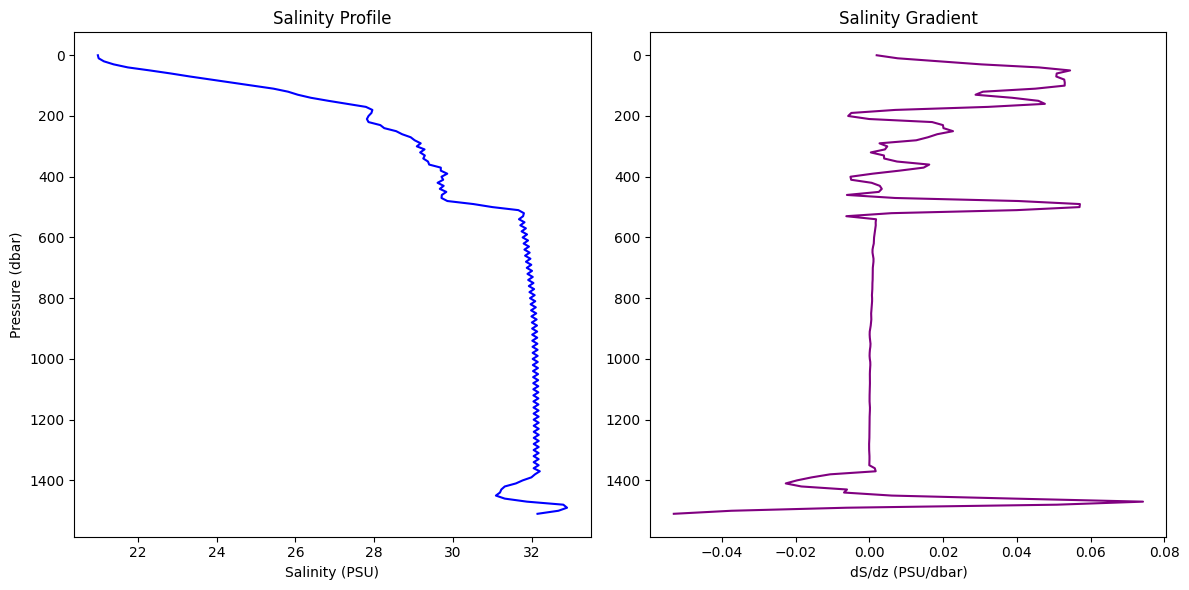

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(df_bin["psal_smooth"], df_bin["pres_bin"], color="blue")
ax[0].invert_yaxis()
ax[0].set_xlabel("Salinity (PSU)")
ax[0].set_ylabel("Pressure (dbar)")
ax[0].set_title("Salinity Profile")

ax[1].plot(df_bin["dS_dz"], df_bin["pres_bin"], color="purple")
ax[1].invert_yaxis()
ax[1].set_xlabel("dS/dz (PSU/dbar)")
ax[1].set_title("Salinity Gradient")

plt.tight_layout()
plt.show()


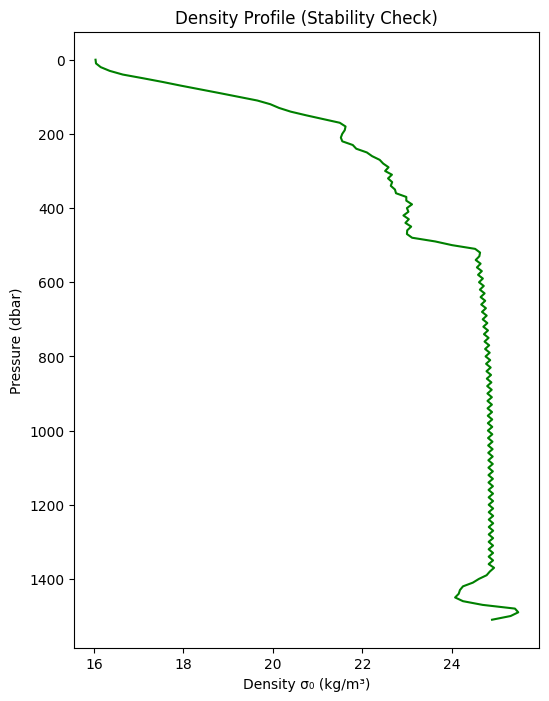

In [ ]:
plt.figure(figsize=(6, 8))
plt.plot(df_bin["density_sigma0"], df_bin["pres_bin"], color="green")
plt.gca().invert_yaxis()
plt.xlabel("Density σ₀ (kg/m³)")
plt.ylabel("Pressure (dbar)")
plt.title("Density Profile (Stability Check)")
plt.show()


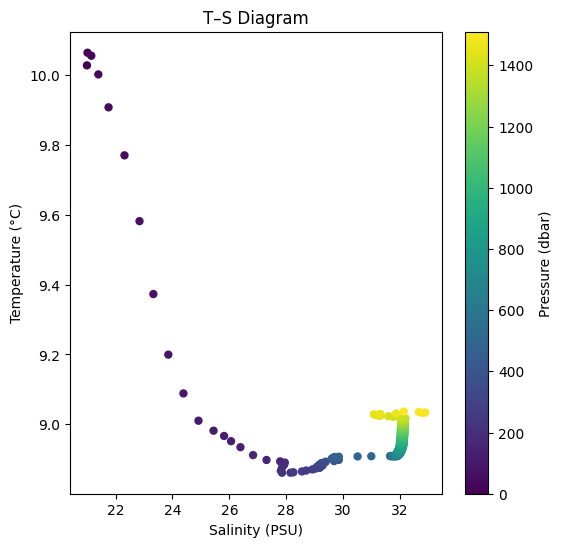

In [ ]:
plt.figure(figsize=(6, 6))

plt.scatter(
    df_bin["psal_smooth"],
    df_bin["temp_smooth"],
    c=df_bin["pres_bin"],
    cmap="viridis",
    s=25
)

plt.colorbar(label="Pressure (dbar)")
plt.xlabel("Salinity (PSU)")
plt.ylabel("Temperature (°C)")
plt.title("T–S Diagram")
plt.show()


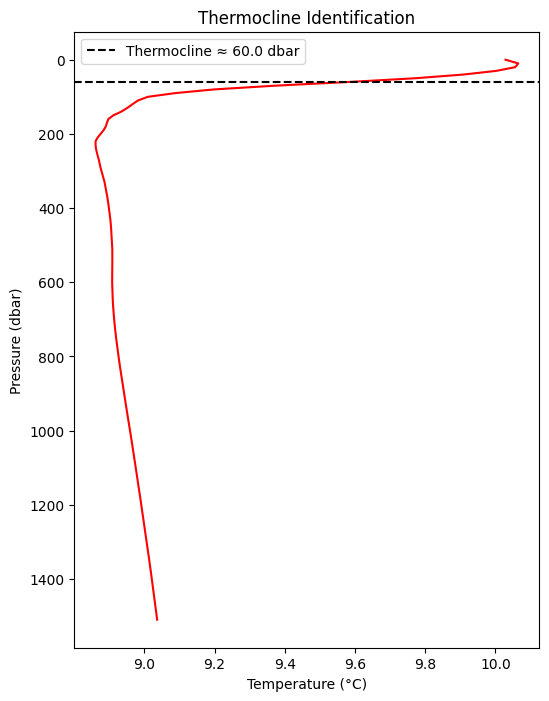

In [ ]:
plt.figure(figsize=(6, 8))

plt.plot(df_bin["temp_smooth"], df_bin["pres_bin"], "r")
plt.axhline(
    thermocline_depth,
    linestyle="--",
    color="black",
    label=f"Thermocline ≈ {thermocline_depth} dbar"
)

plt.gca().invert_yaxis()
plt.xlabel("Temperature (°C)")
plt.ylabel("Pressure (dbar)")
plt.legend()
plt.title("Thermocline Identification")
plt.show()


In [ ]:
profile_summary = {
    "surface_temp": float(df_bin["temp_smooth"].iloc[0]),
    "bottom_temp": float(df_bin["temp_smooth"].iloc[-1]),
    "surface_salinity": float(df_bin["psal_smooth"].iloc[0]),
    "bottom_salinity": float(df_bin["psal_smooth"].iloc[-1]),
    "thermocline_depth_dbar": float(thermocline_depth),
    "stable_density_column": bool(
        np.all(np.diff(df_bin["density_sigma0"]) > 0)
    )
}

profile_summary


{'surface_temp': 10.028672971239699,
 'bottom_temp': 9.036416590823084,
 'surface_salinity': 20.990650760609242,
 'bottom_salinity': 32.139171755523606,
 'thermocline_depth_dbar': 60.0,
 'stable_density_column': False}